# Logistic regression of mouse behaviour data
## Using softmax in tensorflow

#### M.Evans 02.06.16

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import seaborn as sns # caused kernel to die 02.06.16
import random
# from scipy.signal import decimate

In [13]:
%matplotlib inline
# from IPython import display # For plotting intermediate results

In [3]:
# ! pip install pandas
# ! pip install seaborn
import seaborn as sns

In [4]:
# Import the data. For one mouse ATM
theta = pd.read_csv('~/work/whiskfree/data/theta_36.csv',header=None)
kappa = pd.read_csv('~/work/whiskfree/data/kappa_36.csv',header=None)
tt = pd.read_csv('~/work/whiskfree/data/trialtype_36.csv',header=None)
ch = pd.read_csv('~/work/whiskfree/data/choice_36.csv',header=None)




In [192]:
from scipy.signal import resample
from scipy.stats import zscore

(1790, 50)


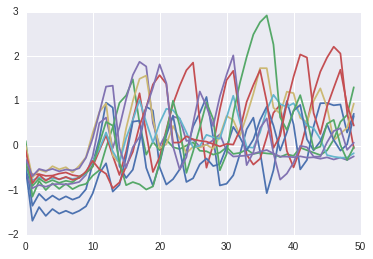

In [226]:
# Restrict analysis to 500ms post-touch and downsample with resample
theta_r = np.array([[resample(theta.values.squeeze()[i,950:1440],50)] for i in range(0,theta.shape[0])])
theta_r = zscore(theta_r.squeeze(),axis=None)
print(theta_r.shape)
_ = plt.plot(theta_r[:10].T)


(1790, 50)


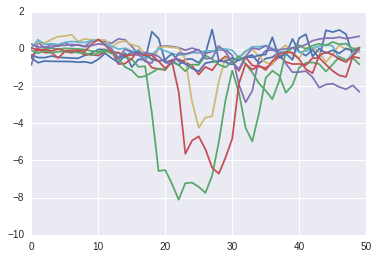

In [230]:
kappa_r = np.array([[resample(kappa.values.squeeze()[i,950:1440],50)] for i in range(0,kappa.shape[0])])
kappa_r = zscore(kappa_r.squeeze(),axis=None)
print(kappa_r.shape)
_ = plt.plot(kappa_r[:10].T)
# _ = plt.plot(zscore(kappa_r[:10],axis=1).T)
# fig,ax = plt.subplots(1,2)
# ax[0].imshow(zscore(kappa_r,axis=None),aspect=float(50/1790),cmap='seismic')
# ax[1].imshow(kappa_r,aspect=float(50/1790),cmap='seismic')


In [228]:
kappa_df = pd.DataFrame(kappa_r)
theta_df = pd.DataFrame(theta_r)

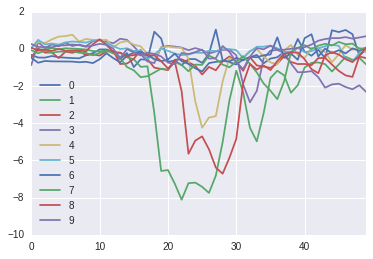

In [229]:
kappa_df[:10].T.plot()

In [231]:
both_df = pd.concat([theta_df,kappa_df],axis=1)
both_df.shape

(1790, 100)

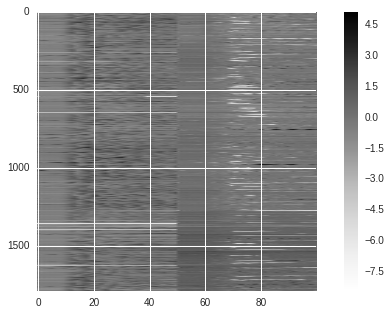

In [232]:
fig, ax = plt.subplots(figsize=(10,5))
plt.imshow(both_df.values.squeeze(),aspect=float(100/1790))
plt.colorbar()

In [44]:
np.mean?

## Trying to classify trialtype from theta/kappa/both

In [244]:
# First generate a clean datasets, dropping trialtype = 0, as numpy arrays
clean = tt.values !=0
tt_c = tt[tt.values !=0].values
both = both_df.values
both_c = both[clean.squeeze(),:]
both_c.shape

(1764, 100)

(1764, 3)

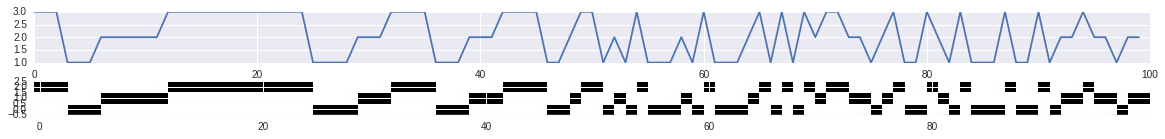

In [160]:
# Turn labels into 'one-hot' array (using a great one-liner from reddit :sunglasses:)
labs = np.eye(3)[tt_c-1]
# y[np.arange(3), a] = 1
labs = labs.squeeze()

fig, ax = plt.subplots(2,1,figsize = (20,2))
ax[0].plot(tt_c[0:100])

ax[1].imshow(labs[0:100,:].T,interpolation = 'none',origin='lower')
labs.shape

In [274]:
# Let's use 20% of the data for testing and 80% for training
trainsize = int(len(both_c) * 0.1)
testsize = len(both_c) - trainsize
print('Desired training/test set sizes:',trainsize, testsize)

subset = random.sample(range(len(both_c)),trainsize)
traindata = both_c[subset,:]
trainlabs = labs[subset,:]
testdata = np.delete(both_c,subset,axis=0)
testlabs = np.delete(labs,subset,axis=0)

print('training set shape:',traindata.shape)
print('test set shape:',testdata.shape)
print('training labels shape:',trainlabs.shape)
print('test labels shape:',testlabs.shape)

Desired training/test set sizes: 176 1588
training set shape: (176, 100)
test set shape: (1588, 100)
training labels shape: (176, 3)
test labels shape: (1588, 3)


In [251]:
# Construct the data flow graph following the TF beginner's MNIST example
x = tf.placeholder(tf.float32,[None,100]) # data

W = tf.Variable(tf.zeros([100,3])) # W and b are model variables to be fit by the model
b = tf.Variable(tf.zeros([3]))     # 3 possible trial types

y = tf.nn.softmax(tf.matmul(x,W) + b) # This is the softmax nn model

y_ = tf.placeholder(tf.float32,[None,3]) # Placeholder for correct answers (test labels)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1])) # Cross entropy loss

train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy) # training step


In [183]:
# Function to load a random batch of data
def next_batch(data,labels,n):
    subset = random.sample(range(len(data)),n) 
    batch_data = data[subset,:]
    batch_labels = labels[subset,:]
    
    return batch_data, batch_labels

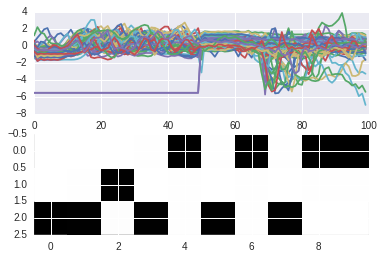

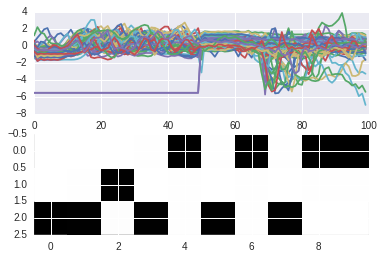

In [250]:
# Test the next_batch function
from IPython import display
fig,ax = plt.subplots(2,1)

for i in range(10):
    batch_xs, batch_ys = next_batch(traindata,trainlabs,10)
    ax[0].plot(batch_xs.T)
    ax[1].imshow(batch_ys.T,interpolation='none')
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [252]:
# Set wheels in motion and train the model
init = tf.initialize_all_variables()

sess = tf.Session() # Start tf session
sess.run(init)



In [254]:
# Run a training loop
for i in range(1000):
    batch_xs, batch_ys = next_batch(traindata,trainlabs,100)
    sess.run(train_step,feed_dict={x: batch_xs, y_: batch_ys})

In [275]:
# Evaluate model performance
correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
print(sess.run(accuracy,feed_dict={x: testdata,y_:testlabs}))

0.338161


In [276]:
# Compare the mouse to the model with a confusion matrix
preds = sess.run(y,feed_dict={x:testdata})
preds

array([[  3.20241898e-02,   3.21266174e-01,   6.46709681e-01],
       [  8.94976253e-08,   9.98730242e-01,   1.26957952e-03],
       [  2.71737040e-03,   9.80933666e-01,   1.63490027e-02],
       ..., 
       [  4.72051650e-01,   3.31862807e-01,   1.96085513e-01],
       [  1.33467302e-01,   4.26601321e-01,   4.39931393e-01],
       [  8.99811804e-01,   3.31032984e-02,   6.70848340e-02]], dtype=float32)

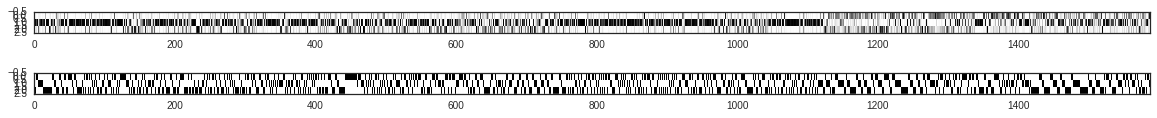

In [277]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(2,1,figsize=[20,2])
ax[0].imshow(preds.T,interpolation='None',aspect = 10)
ax[1].imshow(testlabs.T,interpolation='None',aspect = 10)

(array([ 285.,    0.,    0.,    0.,    0.,  969.,    0.,    0.,    0.,  334.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 10 Patch objects>)

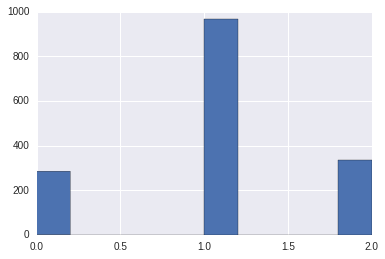

In [287]:
# To do: repeat but with combined data from all mice (interesting to see if this helps)
plt.hist(np.argmax(preds,1))

(array([ 550.,    0.,    0.,    0.,    0.,  464.,    0.,    0.,    0.,  574.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 10 Patch objects>)

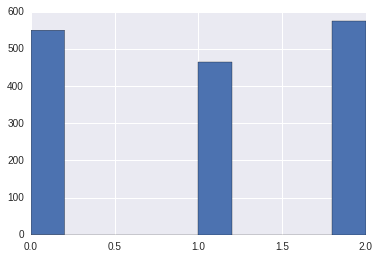

In [288]:
plt.hist(np.argmax(testlabs,1))